### Downloading CIFAR-10 using torchvision

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import PIL
import random as rnd
import seaborn as sns
from sklearn.manifold import TSNE

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(42)


dataset = torchvision.datasets.CIFAR10(root='./',download=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


<PIL.Image.Image image mode=RGB size=32x32 at 0x7F99F5FEFB90> 9
(32, 32)


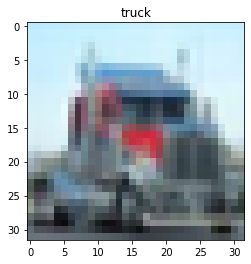

In [5]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

image_indices = np.zeros((10, 5))
labels = np.array(dataset.targets)
# taking first five images of each class
for i in range(10):
  indices = np.where(labels == i)[0]
  image_indices[i] = np.array(indices[0:5])

# print(image_indices)

sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
print(img, label)
plt.title(labels_map[label])
plt.imshow(img)

I = np.array(img)
print(I[:,:, 0].shape)

### ReLU

In [6]:
def reLU(I):
  I[I < 0] = 0
  return I

### Convolution Code

In [7]:
def convolution1(I1, I2):

  N1, M1, _ = I1.shape
  N2, M2, _ = I2.shape

  result = np.zeros((N1, M1))

  # zero padding
  padding = N2 // 2
  npad = ((1, 1), (1, 1), (0, 0))
  padded = np.pad(I, pad_width=npad, mode='constant', constant_values=0)
  

  # for faster calculations
  for i in range(padding, N1 + padding):
    for j in range(padding, M1 + padding):
      result[i - padding, j - padding] = (np.multiply(I2, padded[i - padding: i + padding + 1, j - padding: j + padding + 1, :]).sum())
  return result

In [8]:
def gaussianKernel1(kernel_size):

  M = np.zeros((kernel_size, kernel_size))
  sigma = rnd.uniform(0.5, 5)

  range_beg = -1 * int(kernel_size/2)
  range_end = range_beg + kernel_size

  for x in range(range_beg, range_end):
    for y in range(range_beg, range_end):
      numerator = np.exp(-((x**2) + (y**2)) / (2 * (sigma**2)))
      denominator = 2 * np.pi * (sigma**2)
      M[x - range_beg, y - range_beg] = numerator / denominator

  kernel = np.stack((M, M, M))

  return kernel

def DoG1(kernel_size):
  kernel1 = gaussianKernel1(kernel_size)
  kernel2 = gaussianKernel1(kernel_size)
  return kernel1 - kernel2

In [9]:
def maxPool(I, pool_size, stride=2):

  height, width = I.shape

  # zero padding
  padding = pool_size // 2
  padded = np.pad(I, padding, mode='constant')

  heightRes = int((height - pool_size)/stride + 1)
  widthRes = int((width - pool_size)/stride + 1)
  output = np.zeros((heightRes, widthRes))


  for i in range(0, height, stride):
    if i + pool_size > height:
      break
    for j in range(0, width, stride):
      if j + pool_size > width:
        break
      temp = I[i: i + pool_size, j: j + pool_size]
      output[int(i/stride), int(j/stride)] = np.amax(temp)
  
  return output

In [10]:
def convolution2(I1, I2):

  _, N1, M1 = I1.shape
  _, N2, M2 = I2.shape

  result = np.zeros((N1, M1))

  # zero padding
  padding = N2 // 2
  padded = np.zeros((I1.shape[0], N1 + padding * 2, M1 + padding * 2))

  for i in range(I1.shape[0]):
    padded[i, padding:-padding, padding:-padding] = I1[i, :, :]
    
  # for faster calculations
  for i in range(padding, N1 + padding):
    for j in range(padding, M1 + padding):
      result[i - padding, j - padding] = (np.multiply(I2, padded[:, i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())
  return result

In [11]:
def gaussianKernel2(kernel_size):

  M = np.zeros((kernel_size, kernel_size))
  sigma = rnd.uniform(0.5, 5)

  range_beg = -1 * int(kernel_size/2)
  range_end = range_beg + kernel_size

  for x in range(range_beg, range_end):
    for y in range(range_beg, range_end):
      numerator = np.exp(-((x**2) + (y**2)) / (2 * (sigma**2)))
      denominator = 2 * np.pi * (sigma**2)
      M[x - range_beg, y - range_beg] = numerator / denominator

  kernel = [M, M, M, M]
  kernel = np.array(kernel)

  return kernel

def DoG2(kernel_size):
  kernel1 = gaussianKernel2(kernel_size)
  kernel2 = gaussianKernel2(kernel_size)
  return kernel1 - kernel2

In [12]:
def randomKernel1(kernel_size):
  M = np.random.rand(kernel_size, kernel_size)
  kernel = [M, M, M]
  kernel = np.array(kernel)
  return kernel

def randomKernel2(kernel_size):
  M = np.random.rand(kernel_size, kernel_size)
  kernel = [M, M, M, M]
  kernel = np.array(kernel)
  return kernel

### Layer 1: 4 Kernels

In [13]:
def L1(I, kernel="Gaussian"):
  kernels_1 = []
  layer1 = []

  if kernel == "Random":
    for i in range(4):
      kernel = randomKernel1(3)
      kernels_1.append(kernel)
      layer1.append(reLU(convolution1(I, kernel)))

    L_1 = np.array(layer1)
    # print(L_1.shape)
    return L_1

  for i in range(4):
    kernel = DoG1(3)
    kernels_1.append(kernel)
    layer1.append(reLU(convolution1(I, kernel)))

  L_1 = np.array(layer1)
  # print(L_1.shape)
  return L_1


### Layer 2: Max Pool

In [14]:
def L2(L_1):
  layer2 = []
  for img in L_1:
    layer2.append(maxPool(img, 2))

  L_2 = np.array(layer2)
  # print(L_2.shape)
  return L_2

### Layer 3: 8 Kernels

In [15]:
def L3(L_2, kernel="Gaussian"):
  kernels = []
  layer3 = []

  if kernel == "Random":
    for i in range(8):
      kernel = DoG2(3)
      kernels.append(kernel)
      layer3.append(reLU(convolution2(L_2, kernel)))

    L_3 = np.array(layer3)
    # print(L_3.shape)
    return L_3

  for i in range(8):
    kernel = DoG2(3)
    kernels.append(kernel)
    layer3.append(reLU(convolution2(L_2, kernel)))

  L_3 = np.array(layer3)
  # print(L_3.shape)
  return L_3

### Layer 4: Max Pooling

In [16]:
def L4(L_3):
  layer4 = []
  for img in L_3:
    layer4.append(maxPool(img, 2))

  L_4 = np.array(layer4)
  # print(L_4.shape)
  return L_4

### Layer 5: Flattening

In [17]:
def L5(L_4):
  L_5 = L_4.flatten()
  # L_5 = L_5.reshape(L_5.shape[0], 1)
  # print(L_5.shape)
  return L_5

### Layer 6: MLP

In [21]:
class MLP():
  def __init__(self, input=512, hidden=512, output=10):

    self.input = input 
    self.hidden = hidden
    self.output = output

    self.w1 = np.random.randn(input, hidden) # weights for the hidden layer
    self.w2 = np.random.randn(hidden, output) # weights for the output layer
    self.b1 = np.random.randn(1, hidden) # bias for the hidden layer
    self.b2 = np.random.randn(1, output) # bias for the output layer

    self.z1 = None
    self.a1 = None # activation of the hidden layer
    self.z2 = None
    self.a2 = None # activation of output
  
  def forward(self, X):
    self.z1 = np.dot(X, self.w1) + self.b1
    self.a1 = reLU(self.z1)

    self.z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = reLU(self.z2)

    return self.a2

def L6(L_5):
  layer6 = MLP()
  L_6 = layer6.forward(L_5)
  # print(L_6.shape)
  return L_6


### Forward Pass

In [19]:
def forward(I, plot=False, kernel="Gaussian"):

  # layer 1
  L_1 = L1(I, kernel)
  if plot == True:
    fig1, axis1 = plt.subplots(1, 4, figsize=(10, 30), tight_layout=True)
    for i in range(4):
        axis1[i].imshow(L_1[i])
        axis1[i].set_title("L1: Conv")
  
  # layer 2
  L_2 = L2(L_1)
  if plot == True:
    fig2, axis2 = plt.subplots(1, 4, figsize=(10, 30), tight_layout=True)
    for i in range(4):
        axis2[i].imshow(L_2[i])
        axis2[i].set_title("L2: Pool")

  # layer 3
  L_3 = L3(L_2, kernel)
  if plot == True:
    fig3, axis3 = plt.subplots(1, 8, figsize=(10, 30), tight_layout=True)
    for i in range(8):
        axis3[i].imshow(L_3[i])
        axis3[i].set_title("L3: Conv")

  # layer 4
  L_4 = L4(L_3)
  if plot == True:
    fig4, axis4 = plt.subplots(1, 8, figsize=(10, 30), tight_layout=True)
    for i in range(8):
        axis4[i].imshow(L_4[i])
        axis4[i].set_title("L4: Pool")

  # layer 5
  L_5 = L5(L_4)

  # layer 6
  L_6 = L6(L_5)

  return L_1, L_2, L_3, L_4, L_5, L_6


Gaussian Kernel

(32, 32, 3) (34, 34, 3)
(32, 32, 3) (34, 34, 3)
(32, 32, 3) (34, 34, 3)
(32, 32, 3) (34, 34, 3)


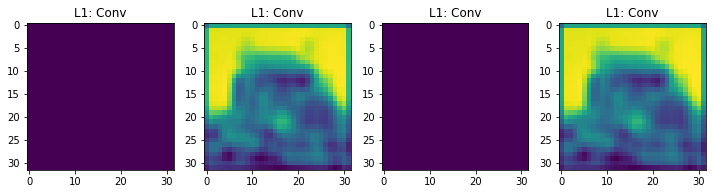

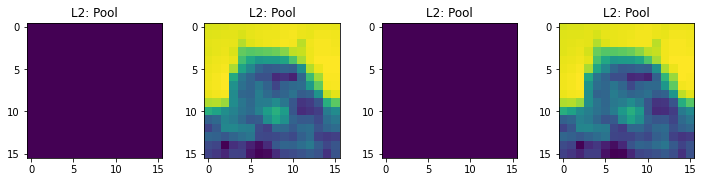

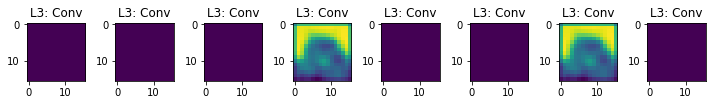

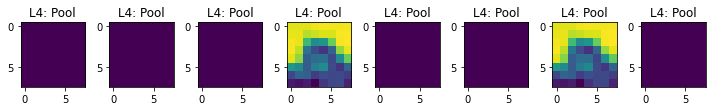

In [22]:
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Gaussian")

Random Kernel

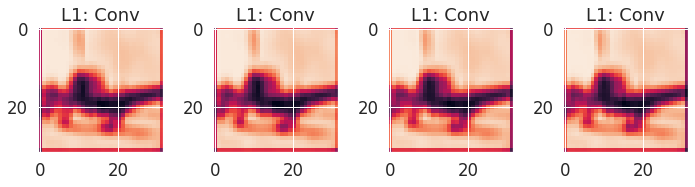

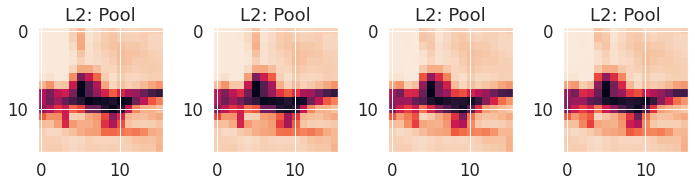

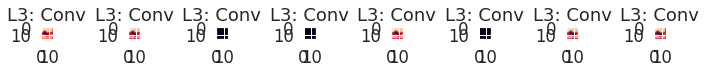

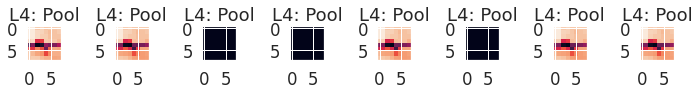

In [ ]:
l1, l2, l3, l4, l5, l6 = forward(I, plot=True, kernel="Random")

### t-SNE Plots

In [ ]:
# The assignment document mentioned we are allowed to use open source code for the t-SNE plots.
# Hence, the t-SNE code was referenced from the following website: 
# https://www.datacamp.com/community/tutorials/introduction-t-sne

import matplotlib.patheffects as PathEffects

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
RS = 123

def fashion_scatter(x, colors):
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

Running the forward propagation for all 50 images

In [ ]:
classes = np.arange(10)
classes = np.repeat(classes, 5)
print(classes)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]


(<Figure size 576x576 with 1 Axes>,
 [Text(46.41307, 17.00999, '0'),
  Text(57.131504, 3.89738, '1'),
  Text(-26.812891, -29.697712, '2'),
  Text(-8.904137, 7.6777024, '3'),
  Text(-16.43308, -3.2633007, '4'),
  Text(-23.932188, -17.676573, '5'),
  Text(2.1266885, -13.679769, '6'),
  Text(18.476212, -12.571315, '7'),
  Text(-10.699137, 3.5203407, '8'),
  Text(-25.279654, -18.485483, '9')])

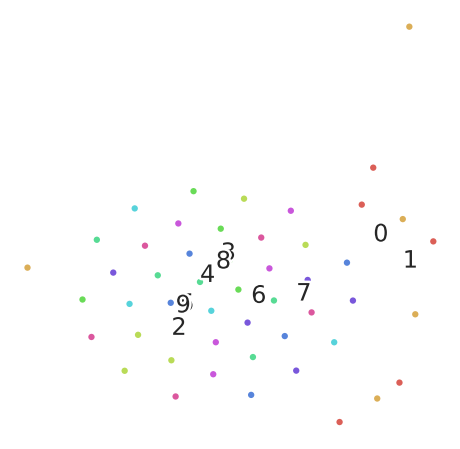

In [ ]:
random_filter = np.zeros((50, 512))

for i in range(image_indices.shape[0]):
  for j in range(image_indices.shape[1]):
    
    img, label = dataset[int(image_indices[i][j])]
    np_I = np.array(img)

    l1, l2, l3, l4, l5, l6 = forward(I, plot=False, kernel="Random")
    random_filter[i] = l5

tsne_random = TSNE(random_state=10).fit_transform(random_filter)
fashion_scatter(tsne_random, classes)


(<Figure size 576x576 with 1 Axes>,
 [Text(41.32126, -5.661493, '0'),
  Text(125.154724, -37.39649, '1'),
  Text(-41.746906, -36.049744, '2'),
  Text(1.6182467, -3.6973708, '3'),
  Text(-17.380672, -14.3734455, '4'),
  Text(41.35582, -1.3564442, '5'),
  Text(4.2047396, 21.05539, '6'),
  Text(-37.83011, -21.92149, '7'),
  Text(-16.199923, 1.6206343, '8'),
  Text(19.574194, 23.430908, '9')])

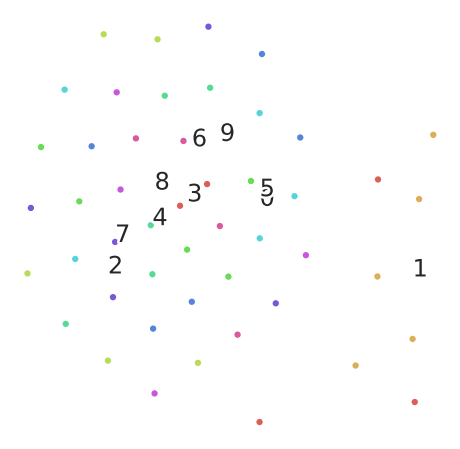

In [ ]:
gaussian_filter = np.zeros((50, 512))

for i in range(image_indices.shape[0]):
  for j in range(image_indices.shape[1]):
    
    img, label = dataset[int(image_indices[i][j])]
    np_I = np.array(img)

    l1, l2, l3, l4, l5, l6 = forward(I, plot=False, kernel="Gaussian")
    gaussian_filter[i] = l5

tsne_gaussian = TSNE(random_state=10).fit_transform(gaussian_filter)
fashion_scatter(tsne_gaussian, classes)


### Observations

The Gaussian filter one seems to have a larger separation between classes.